In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

plt.style.use('fivethirtyeight')

## Formatting Data and Feature Engineering

In [48]:
data_raw = pd.read_csv("atp_data.csv")

In [49]:
#Create Upsets feature
ranks = list(zip(data_raw["WRank"], data_raw["LRank"]))
data_raw["Upset"] = [0 if x[0] < x[1] else 1 for x in ranks]

In [50]:
#Create elo difference feature
data_raw["elo_diff"] = np.abs(data_raw["elo_winner"] - data_raw["elo_loser"])

In [51]:
#create rank diff and log rank diff features
data_raw["rank_diff"] = np.abs(data_raw["WRank"] - data_raw["LRank"])
data_raw["log_rank_diff"] = np.log(np.abs(data_raw["WRank"] - data_raw["LRank"]))

/home/marcel/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
#Drop infinity and NaN
data_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
data_raw = data_raw.dropna()
data_raw = data_raw.reset_index(drop = True)

In [53]:
#Datetime
data_raw["Date"] = pd.to_datetime(data_raw["Date"])

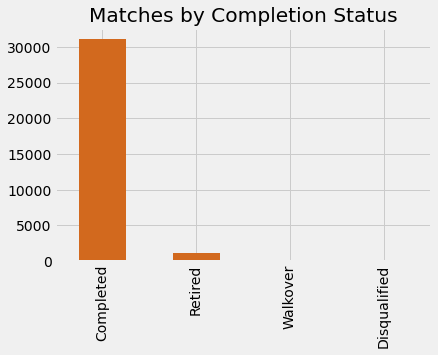

In [54]:
#PLot to see how many non-completed matches there are
data_raw["Comment"].value_counts().plot(kind = 'bar', color = "chocolate")
plt.title("Matches by Completion Status")
plt.show()

In [55]:
#Remove non-completed matches
data_raw[data_raw["Comment"] == "Completed"]
data_raw = data_raw.reset_index(drop = True)
data_raw = data_raw.drop("Comment", axis = 1)

In [56]:
#write to CSV
data_raw.to_csv("ATP_cleaned.csv")

## Initial Plots

In [2]:
atp_data = pd.read_csv("ATP_cleaned.csv", index_col = 0)

In [3]:
atp_data["Date"] = pd.to_datetime(atp_data["Date"])

In [4]:
surface = atp_data.groupby(["Surface"])[["Upset"]].sum().reset_index()

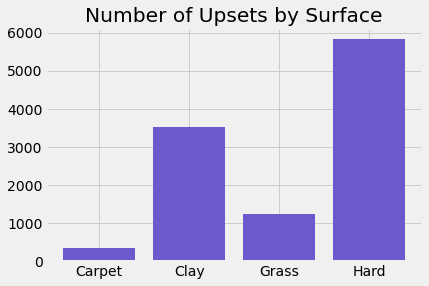

In [5]:
plt.bar(surface["Surface"], surface["Upset"], color = "slateblue")
plt.title("Number of Upsets by Surface")
plt.show()

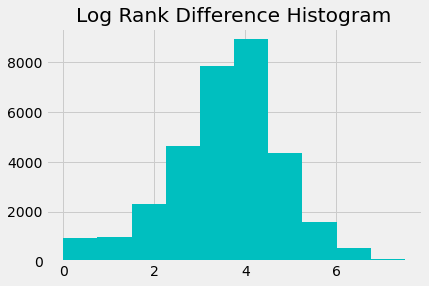

In [6]:
plt.hist(atp_data["log_rank_diff"], color = 'c')
plt.title("Log Rank Difference Histogram")
plt.show()

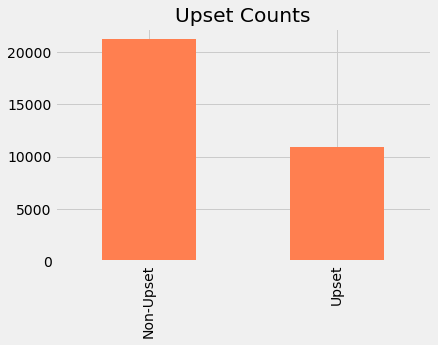

In [7]:
ax = atp_data["Upset"].value_counts().plot(kind = 'bar', color = "coral")
plt.title("Upset Counts")
ax.set_xticklabels(["Non-Upset","Upset"])
plt.show()

## Scaling Data For Modeling

In [8]:
scaler = MinMaxScaler()
df = atp_data[["WRank","LRank", 
              "elo_winner", "elo_loser",
              "elo_diff",  "rank_diff",
             "log_rank_diff"]]
scaled_x = scaler.fit_transform(df.to_numpy())
scaled_x = pd.DataFrame(scaled_x, columns=["WRank","LRank", 
              "elo_winner", "elo_loser",
              "elo_diff", "rank_diff",
             "log_rank_diff"])

In [9]:
scaled_x = pd.concat([scaled_x, pd.get_dummies(atp_data["Court"]),
                      pd.get_dummies(atp_data["Surface"]),
                      pd.get_dummies(atp_data["Round"])], axis =1)
y = atp_data["Upset"]

Adding tournament made the models much worse, too many additional dummy variables seemed to confuse the models

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, 
                                        y, test_size=0.2, random_state=0)

### Upsample training data

Upsampling was able to somewhat improve the models, but it sacrificed precision for a higher recall in the tree models

In [11]:
from sklearn.utils import resample
X_train["Upset"] = y_train
df_min = X_train[X_train["Upset"] == 1]
df_maj = X_train[X_train["Upset"] == 0]
df_min_up = resample(df_min, replace=True, n_samples=16000,random_state=0)
X_train = pd.concat([df_maj, df_min_up])
y_train = X_train["Upset"]
X_train = X_train.drop("Upset", axis = 1)

## Modeling KNN (n=5)

In [12]:
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [13]:
pred = neigh.predict(X_test)

In [14]:
cm = confusion_matrix(y_test, pred)

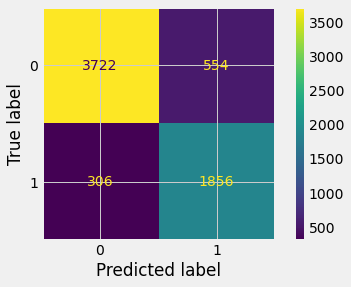

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=neigh.classes_)
disp.plot()
plt.show()

In [16]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.8664181422802113
Precision: 0.7701244813278009
Recall: 0.8584643848288621
F1: 0.8118985126859143


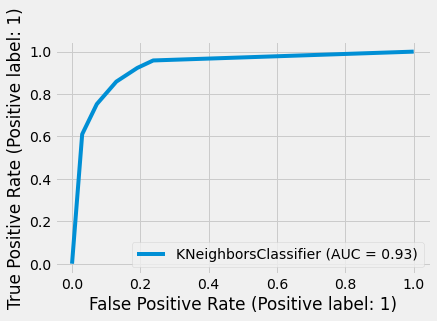

In [17]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(neigh, X_test, y_test)
plt.show()

## Modeling Logistic Regression

In [18]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
pred = lr.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, pred)

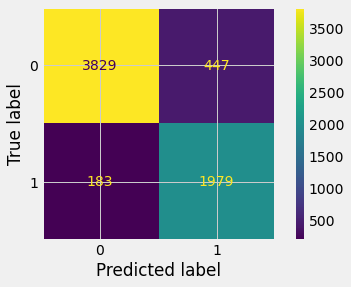

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=neigh.classes_)
disp.plot()
plt.show()

In [22]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.902143522833178
Precision: 0.8157460840890355
Recall: 0.9153561517113784
F1: 0.8626852659110725


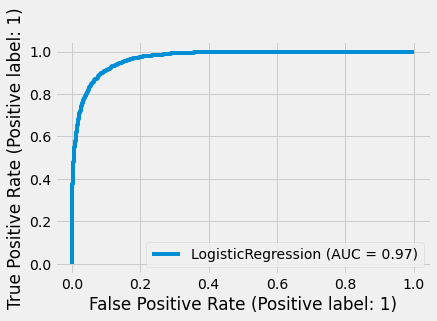

In [23]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=3, n_estimators = 100)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [25]:
pred = rfc.predict(X_test)

In [26]:
cm = confusion_matrix(y_test, pred)

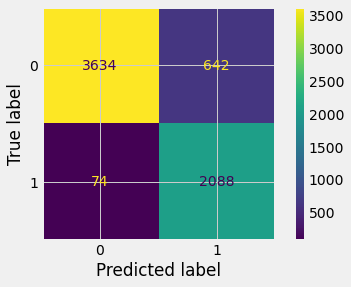

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=neigh.classes_)
disp.plot()
plt.show()

In [28]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.8887853370611991
Precision: 0.7648351648351648
Recall: 0.96577243293247
F1: 0.8536385936222404


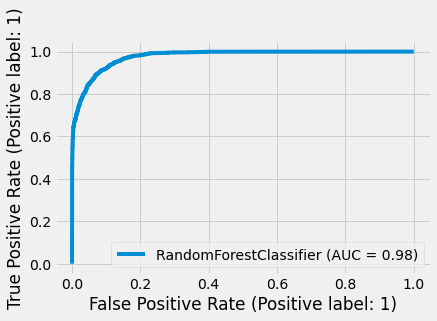

In [29]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.show()

## Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

In [31]:
etc = ExtraTreesClassifier(max_depth=3, n_estimators = 100)
etc.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=3)

In [32]:
pred = etc.predict(X_test)

In [33]:
cm = confusion_matrix(y_test, pred)

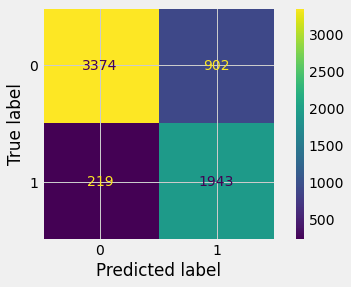

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=neigh.classes_)
disp.plot()
plt.show()

In [35]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.8258776017396707
Precision: 0.6829525483304042
Recall: 0.8987049028677151
F1: 0.7761134411823448


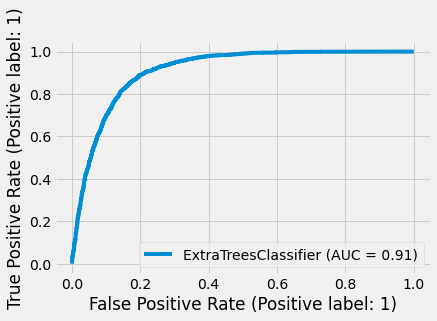

In [36]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(etc, X_test, y_test)
plt.show()

## Random Forest Grid Search CV

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [38]:
rf_model = RandomForestClassifier()
params={"max_depth": range(5,20,5), "min_samples_leaf": range(1,15,5),
         "n_estimators":[10,400],'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:8}]}
model_names =  "rf_model"
parameters_list=[params]
model_log= "_rf"
scaler = StandardScaler()
Grid=GridSearchCV(estimator=rf_model, param_grid=parameters_list, scoring='roc_auc',
                      n_jobs=-1, cv=3, verbose=3)
    
model=Grid.fit(X_train,y_train)
        
globals()['Grid%s' % model_log] =pd.DataFrame(Grid.cv_results_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


In [39]:
model.best_score_

0.9998016959230047

In [40]:
final_model= model.best_estimator_
final_model

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=15,
                       n_estimators=400)

In [41]:
rfc2 = final_model
rfc2.fit(X_train, y_train)
pred = rfc2.predict(X_test)

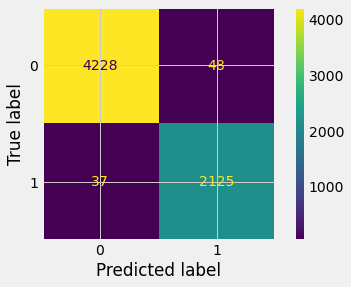

In [42]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=neigh.classes_)
disp.plot()
plt.show()

In [43]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.9867971419695558
Precision: 0.9779107225034515
Recall: 0.982886216466235
F1: 0.9803921568627452


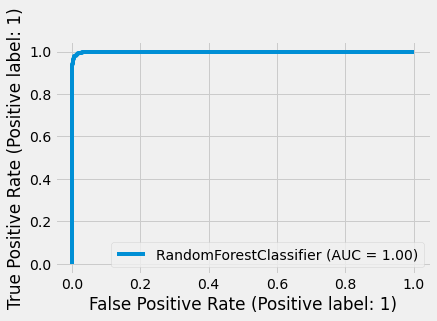

[CV 2/3] END class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=6, n_estimators=10;, score=0.988 total time=   0.2s
[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=11, n_estimators=400;, score=0.994 total time=   7.5s
[CV 3/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=1, n_estimators=10;, score=0.999 total time=   0.3s
[CV 3/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=1, n_estimators=400;, score=1.000 total time=  11.5s
[CV 2/3] END class_weight={0: 1, 1: 2}, max_depth=5, min_samples_leaf=6, n_estimators=10;, score=0.978 total time=   0.2s
[CV 2/3] END class_weight={0: 1, 1: 2}, max_depth=5, min_samples_leaf=6, n_estimators=400;, score=0.990 total time=   6.9s
[CV 3/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=6, n_estimators=10;, score=0.997 total time=   0.3s
[CV 3/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=6, n_estimators=400;, score=0.999 total time=  10.7s
[CV 3/3] END cl

[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=1, n_estimators=400;, score=0.995 total time=   6.9s
[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=6, n_estimators=10;, score=0.998 total time=   0.3s
[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=6, n_estimators=400;, score=1.000 total time=  10.2s
[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=11, n_estimators=10;, score=0.999 total time=   0.3s
[CV 1/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=11, n_estimators=400;, score=1.000 total time=  10.7s
[CV 1/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=11, n_estimators=10;, score=0.997 total time=   0.3s
[CV 1/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=11, n_estimators=400;, score=0.999 total time=  10.5s
[CV 3/3] END class_weight={0: 1, 1: 4}, max_depth=5, min_samples_leaf=1, n_estimators=10;, score=0.987 total time=   0.2s
[CV 3/3] E

[CV 2/3] END class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=6, n_estimators=400;, score=0.993 total time=   7.4s
[CV 3/3] END class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=11, n_estimators=10;, score=0.996 total time=   0.3s
[CV 2/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=1, n_estimators=10;, score=0.999 total time=   0.3s
[CV 2/3] END class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=1, n_estimators=400;, score=1.000 total time=  11.6s
[CV 3/3] END class_weight={0: 1, 1: 2}, max_depth=5, min_samples_leaf=6, n_estimators=10;, score=0.984 total time=   0.2s
[CV 3/3] END class_weight={0: 1, 1: 2}, max_depth=5, min_samples_leaf=6, n_estimators=400;, score=0.992 total time=   6.6s
[CV 1/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=6, n_estimators=10;, score=0.998 total time=   0.3s
[CV 1/3] END class_weight={0: 1, 1: 2}, max_depth=10, min_samples_leaf=6, n_estimators=400;, score=0.999 total time=   9.7s
[CV 1/3] END c

In [44]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc2, X_test, y_test)
plt.show()